In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('Data/train_data_new.csv', usecols=['file', 'sample','ENC_POS_FLOATMAG_BH', 'dENC_X', 'ddENC_X', 'FLOATMAG_ACC_ADC_PORT_0', 'DAC_FLOATMAG_BH']).dropna()
test = pd.read_csv('Data/test_data_new.csv', usecols=['file', 'sample','ENC_POS_FLOATMAG_BH', 'dENC_X', 'ddENC_X', 'FLOATMAG_ACC_ADC_PORT_0', 'DAC_FLOATMAG_BH']).dropna()
# train = pd.read_csv('Data/train_data_new.csv', usecols=['file', 'sample','ENC_POS_FLOATMAG_BH', 'dENC_X', 'ddENC_X', 'FLOATMAG_ACC_ADC_PORT_0', 'DAC_FLOATMAG_BH'])
# test = pd.read_csv('Data/test_data_new.csv', usecols=['file', 'sample','ENC_POS_FLOATMAG_BH', 'dENC_X', 'ddENC_X', 'FLOATMAG_ACC_ADC_PORT_0', 'DAC_FLOATMAG_BH'])

train, test

(        sample  ENC_POS_FLOATMAG_BH  dENC_X  ddENC_X  FLOATMAG_ACC_ADC_PORT_0  \
 2            2                  1.0     0.0     -3.0                    114.0   
 3            3                  2.0     1.0      1.0                    -76.0   
 4            4                  2.0     0.0     -1.0                     49.0   
 5            5                  0.0    -2.0     -2.0                    -10.0   
 6            6                 -1.0    -1.0      1.0                     41.0   
 ...        ...                  ...     ...      ...                      ...   
 210217    3873             100001.0     0.0     -2.0                    243.0   
 210218    3874             100000.0    -1.0     -1.0                     46.0   
 210219    3875             100004.0     4.0      5.0                     85.0   
 210220    3876             100000.0    -4.0     -8.0                    -26.0   
 210221    3877             100001.0     1.0      5.0                    -64.0   
 
         DAC_F

In [4]:
prediction_timestep = 1

train["target"] = train.groupby("file")["FLOATMAG_ACC_ADC_PORT_0"].shift(-prediction_timestep)
test["target"] = test.groupby("file")["FLOATMAG_ACC_ADC_PORT_0"].shift(-prediction_timestep)

In [43]:
X = train[["ENC_POS_FLOATMAG_BH", "dENC_X", "ddENC_X", "DAC_FLOATMAG_BH", "target"]].dropna()
y = X.pop("target")
y = np.expand_dims(y, axis=-1)

X_test = test[["ENC_POS_FLOATMAG_BH", "dENC_X", "ddENC_X", "DAC_FLOATMAG_BH", "target"]].dropna()
y_test = X_test.pop("target")
y_test = np.expand_dims(y_test, axis=1)

In [45]:
X.shape, y.shape, X_test.shape, y_test.shape

((210150, 4), (210150, 1), (15628, 4), (15628, 1))

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Normalization

mae = tf.keras.metrics.mean_absolute_error

2023-11-06 02:49:19.833207: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-06 02:49:19.928284: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-06 02:49:19.928378: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-06 02:49:19.928615: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-06 02:49:19.980503: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-06 02:49:19.982063: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [46]:
input_norm = Normalization(axis=-1)

input_norm.adapt(X)

In [48]:
output_norm = Normalization(axis=-1)

output_norm.adapt(y)

In [89]:
model = Sequential([
    Input(shape=(4,)),  # Input shape: 10 timesteps with 4 features each
    input_norm,
    Dense(200),
    Dense(50),
    Dense(50),
    Dense(20),
    Dense(1)  # Output layer with 1 unit
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [52]:
one_trial_test = test[test["file"] == 24][["ENC_POS_FLOATMAG_BH", "dENC_X", "ddENC_X", "DAC_FLOATMAG_BH", "target"]]

X_test_one_trial = one_trial_test[["ENC_POS_FLOATMAG_BH", "dENC_X", "ddENC_X", "DAC_FLOATMAG_BH", "target"]].dropna()
y_test_one_trial = X_test_one_trial.pop("target")
y_test_one_trial = np.expand_dims(y_test_one_trial, axis=1)

In [55]:
X_test_one_trial.shape, y_test_one_trial.shape

((3627, 4), (3627, 1))

In [56]:
inverse_output_norm = Normalization(axis=-1, invert=True)

inverse_output_norm.adapt(y)

In [86]:
# #lets have a mapping function just adds 6 to the normalized y values if > 0 and -6 if < 0


# def mapping_func(normalized_y):
    
#     return np.where(normalized_y > 0, normalized_y + 6, normalized_y - 6)

# def inverse_mapping_func(predictions):

#     return np.where(predictions > 0, predictions - 6, predictions + 6)

epoch 0
Epoch 1/2
6568/6568 [==============================] - 11s 2ms/step - loss: 0.3013 - mae: 0.2867 - val_loss: 0.4989 - val_mae: 0.4865
Epoch 2/2
114/114 [==============================] - 0s 956us/step


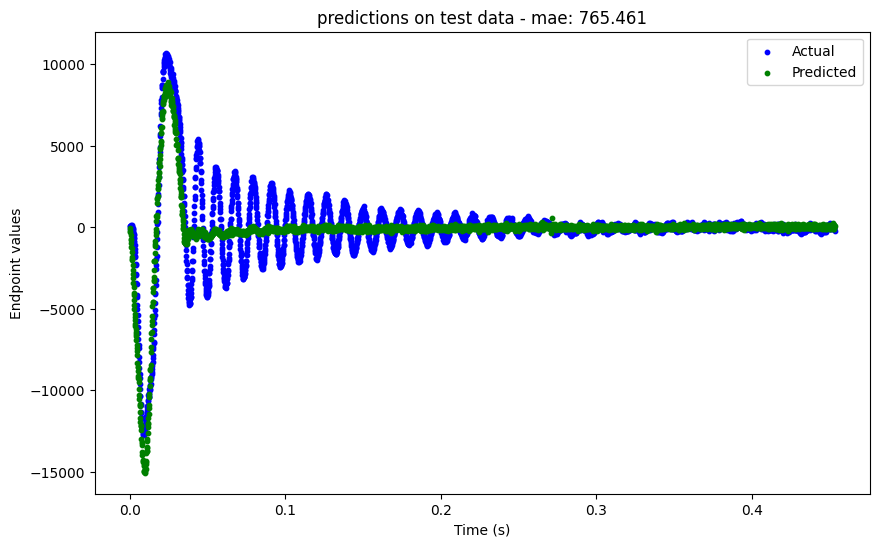

epoch 1
Epoch 1/2
6568/6568 [==============================] - 10s 2ms/step - loss: 0.2982 - mae: 0.2869 - val_loss: 0.4979 - val_mae: 0.4826
Epoch 2/2
114/114 [==============================] - 0s 958us/step


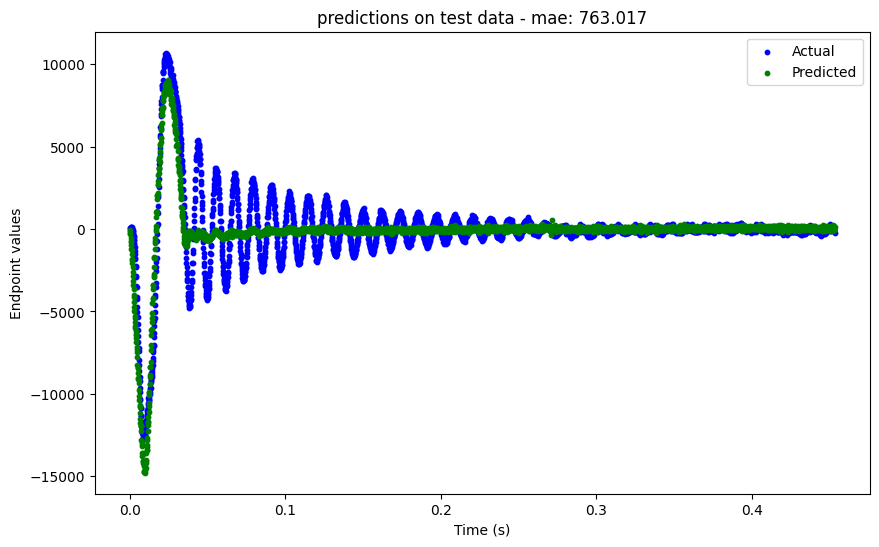

epoch 2
Epoch 1/2
6568/6568 [==============================] - 10s 2ms/step - loss: 0.2980 - mae: 0.2868 - val_loss: 0.5029 - val_mae: 0.4882
Epoch 2/2
114/114 [==============================] - 0s 968us/step


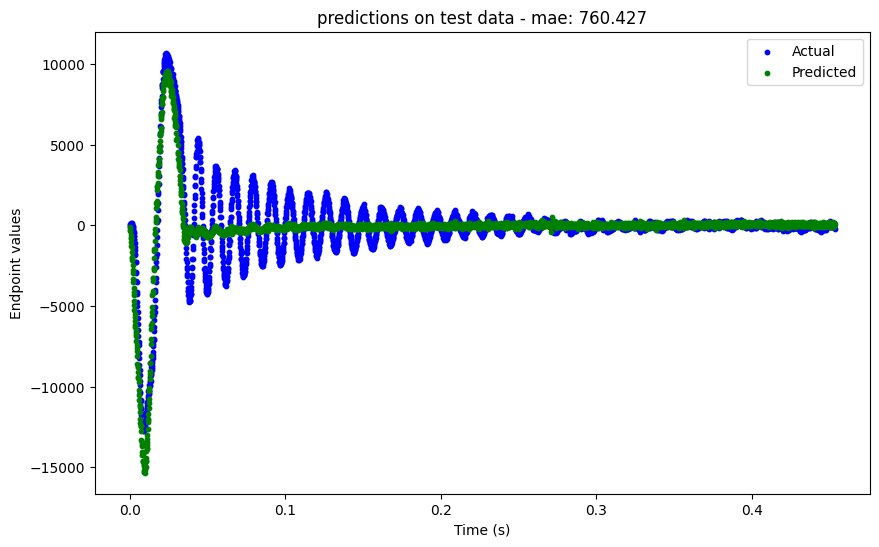

epoch 3
Epoch 1/2
6568/6568 [==============================] - 10s 2ms/step - loss: 0.2981 - mae: 0.2869 - val_loss: 0.5047 - val_mae: 0.4887
Epoch 2/2
114/114 [==============================] - 0s 1ms/step


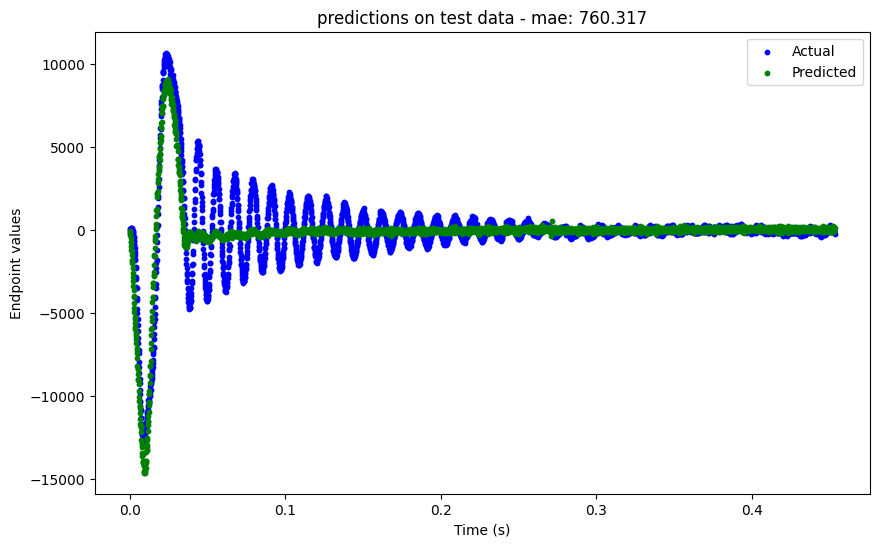

epoch 4
Epoch 1/2
6568/6568 [==============================] - 10s 2ms/step - loss: 0.2981 - mae: 0.2869 - val_loss: 0.4996 - val_mae: 0.4865
Epoch 2/2
114/114 [==============================] - 0s 1ms/step


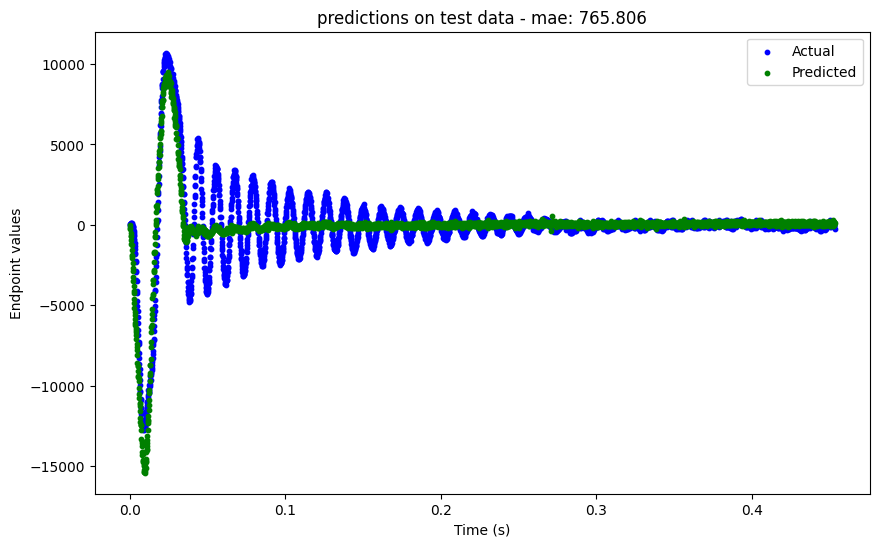

epoch 5
Epoch 1/2
6568/6568 [==============================] - 11s 2ms/step - loss: 0.2979 - mae: 0.2868 - val_loss: 0.4982 - val_mae: 0.4860
Epoch 2/2
114/114 [==============================] - 0s 961us/step


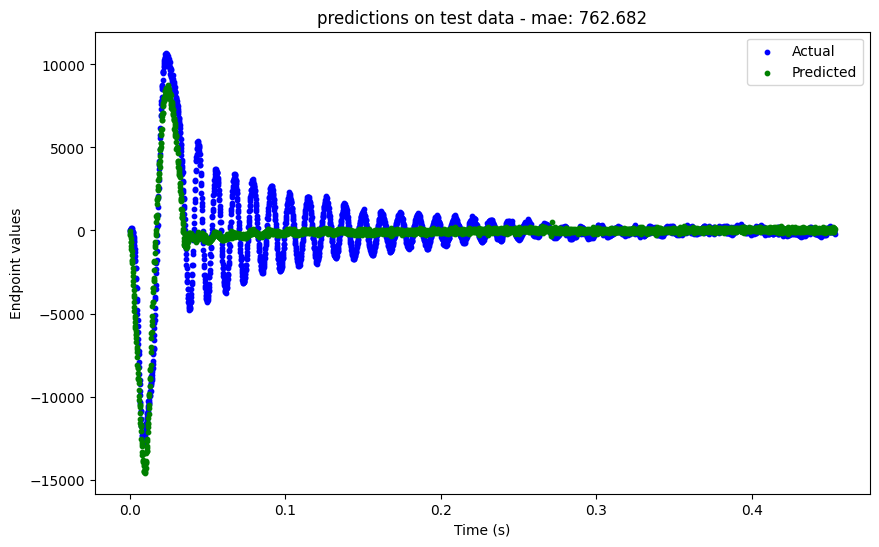

epoch 6
Epoch 1/2
6568/6568 [==============================] - 10s 2ms/step - loss: 0.2979 - mae: 0.2868 - val_loss: 0.4995 - val_mae: 0.4847
Epoch 2/2
114/114 [==============================] - 0s 1ms/step


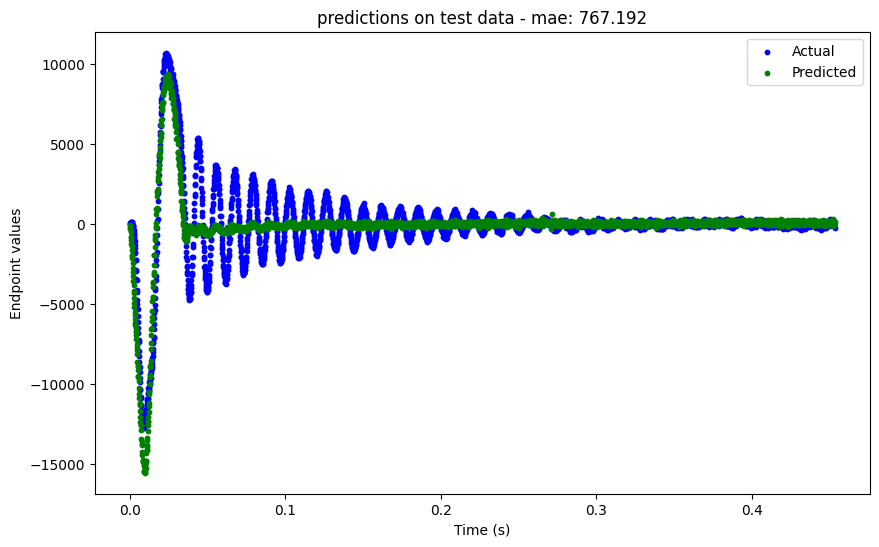

epoch 7
Epoch 1/2
6568/6568 [==============================] - 10s 2ms/step - loss: 0.2979 - mae: 0.2868 - val_loss: 0.5003 - val_mae: 0.4870
Epoch 2/2
114/114 [==============================] - 0s 932us/step


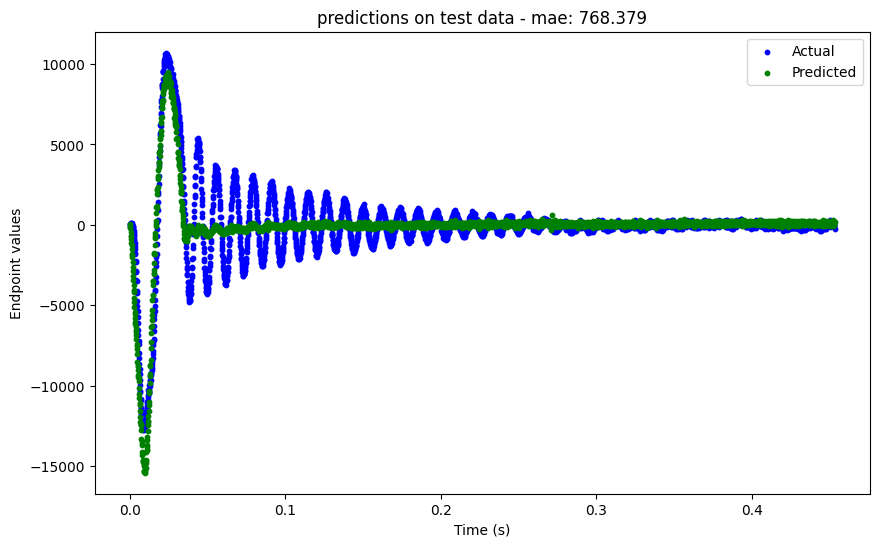

epoch 8
Epoch 1/2
6568/6568 [==============================] - 10s 2ms/step - loss: 0.2979 - mae: 0.2870 - val_loss: 0.4986 - val_mae: 0.4837
Epoch 2/2
114/114 [==============================] - 0s 964us/step


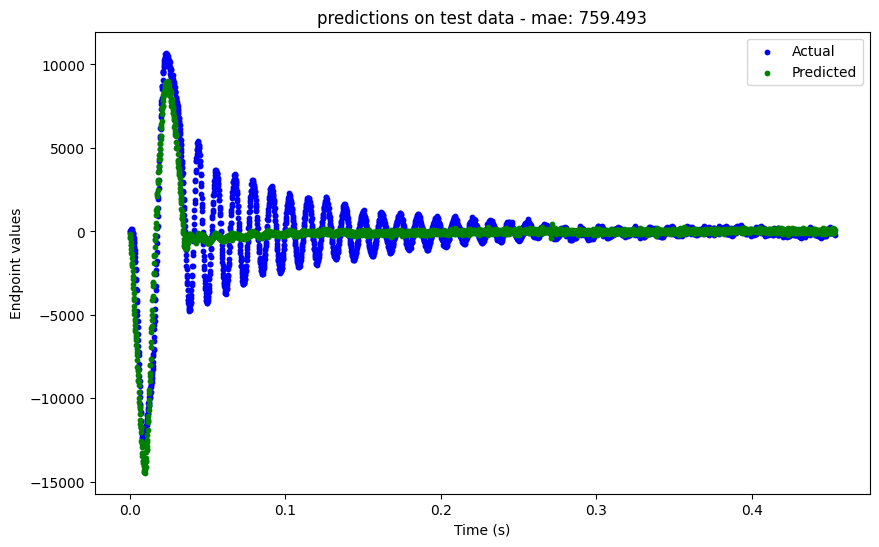

epoch 9
Epoch 1/2
6568/6568 [==============================] - 10s 2ms/step - loss: 0.2976 - mae: 0.2867 - val_loss: 0.5011 - val_mae: 0.4886
Epoch 2/2
114/114 [==============================] - 0s 960us/step


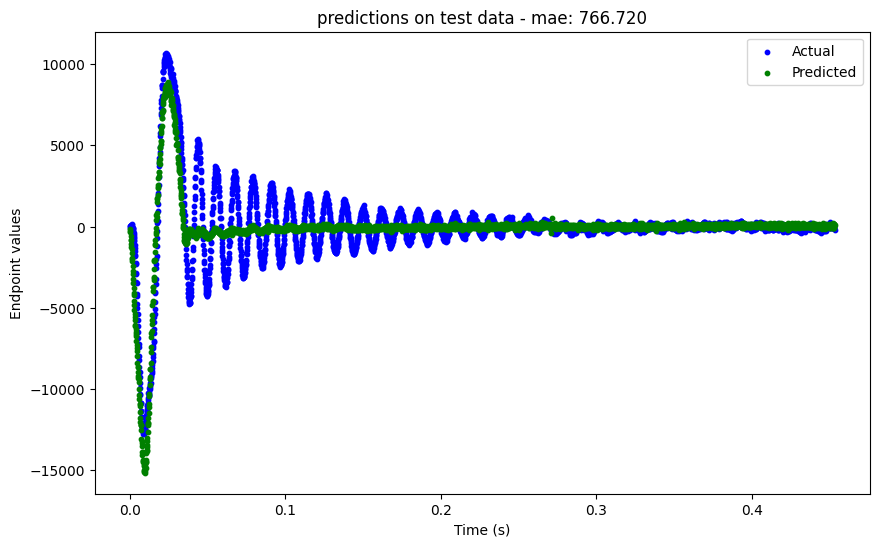

In [91]:
for i in range(10):
    print(f"epoch {i}")

    # history = model.fit(X, mapping_func(output_norm(y)), epochs=2, batch_size=32, validation_data = (X_test, mapping_func(output_norm(y_test))))
    history = model.fit(X, output_norm(y), epochs=2, batch_size=32, validation_data = (X_test, output_norm(y_test)))

    #with output normalization
    times = np.array(range(len(X_test_one_trial))) / 8000

    predictions_one_trial = model.predict(X_test_one_trial)
    
    mae_test = mae(y_test_one_trial.flatten(), inverse_output_norm(predictions_one_trial).numpy().flatten())
    # mae_test = mae(y_test_one_trial.flatten(), inverse_output_norm(inverse_mapping_func(predictions_one_trial)).numpy().flatten())

    # Visualize predictions vs actual values
    plt.figure(figsize=(10, 6))
    plt.scatter(times, y_test_one_trial.flatten(), color='blue', label='Actual', s = 10)
    plt.scatter(times, inverse_output_norm(predictions_one_trial).numpy(), color='green', label='Predicted', s=10)
    # plt.scatter(times, inverse_output_norm(inverse_mapping_func(predictions_one_trial)).numpy(), color='green', label='Predicted', s=10)


    # plt.title(f'predictions on test data - RMSE: {rmse_test:.3f}')
    plt.title(f'predictions on test data - mae: {mae_test:.3f}')

    plt.xlabel('Time (s)')
    plt.ylabel('Endpoint values')
    plt.legend()
    plt.show()

In [ ]:
#ok so basically what we are getting from this is that there is not much differentiation in the input data to be able to predict the output data past the transient bit
#so how do we fix this?
#need to process the input data further, ie there is a huge range of values, and normalization does not capture the small encoder vibrations well i am assuming
